# __ASE Orbital Materials Implementation__
This notebook contains the installation procedure and initial testing provided in the Orbital Materials [GitHub](https://github.com/orbital-materials/orb-models/tree/main) and the ~~[documentation]()~~ (non existent). Note that Orbital Materials (from now on 'Ortbial') is only a pretrained model (two versions: large and small). The architecture is discussed in its paper. 

The architecture is not open, i.e. given a new set of training data, the package does not allow for training/evaluation of new models with different training data. The training process and fine-tuning of the model is not directly available with the package... the architecture must be exported and base DL packages (pytorch or tensorflow) must be used...

### __Installation procedure__
Refer to ASE installation for the basics of the miniconda `venv` where Orbital will be installed. This ensures that other calculators will not break the environment.
- ASE installation process
    - Create new conda environment (python 3.10 is standard). Check the Python requirement for the external calculator wanted. Usually  `python>3.9`.  
    - `conda install ase` (installs `scipy` and `numpy` dependencies) and `conda install matplotlib`. 
    - Check the environment works installing `conda install pytest` and `ase test`.
    - For ASE representations inside Jupyter Notebook, conda install `notebook`, `ipywidgets` and `nglview`. 
- Orbital installation process
    - Clone base ASE environment. 
    - `pip install orb-models` to install the orbital models (small and large). 
    - `pip install "pynanoflann@git+https://github.com/dwastberg/pynanoflann#egg=af434039ae14bedcbb838a7808924d6689274168"`. This effectively installs `pynanoflann-0.0.9` directly from the git repo. 
    - Once installed, use `conda clean --all`

- Additional packages installed for convenience: `py3dmol`. 

**Note.** `orb-models` uses torch and some weird (and sus) google packages. 

### __References__

[TUTORIAL FILES] CHECK GITHUB


## __Orbital pretrained models__
Orbital provides an interface to ASE via a calculator class named `ORBCalculator`, which can be found in `orb_models/forcefield/calculator.py`. Orbital models can be found in `forcefield/pretrained.py` and a list of models is provided in the [GitHub](https://github.com/orbital-materials/orb-models/tree/main/?tab=readme-ov-file#pretrained-models). There is no documentation available, so the source is used. 

- `orb-v2`
    - Trained on `MPTraj` and `Alexandria`. In this sense, it is the same training dataset as `MACE-MPA-0` (trained on `MPTraj` and `sAlex`). 

- `orb-d3-v2`
    - Same as `orb-v2` but with integrated D3 dispersion corrections. Variations of this model include `orb-d3-sm-v2` (small version, 10 layers) and `orb-d3-xs-v2` (extra small version, with 5 layers). 

- `orb-mptraj-only-v2`
    - Only trained on `MPTraj`. 

- `ORBCalculator`    

In [1]:
# orbital imports
from orb_models.forcefield.calculator import ORBCalculator
from orb_models.forcefield import atomic_system

# import the forcefields
from orb_models.forcefield.pretrained import (
    orb_v2, orb_d3_v2, orb_mptraj_only_v2,
)

orbff = orb_v2(
    # core settings
    device='cpu',           # device, 'cuda' or 'cpu'
    #weights_path=...       # defined via a AWS link
    ) 

orbff = orb_d3_v2(
    device='cpu'
    # same settings as orb_v2()
    )

calc = ORBCalculator(
    model=orbff,            # NNP to be used
    device='cpu',            # device, 'cuda' or 'cpu'. 
    )

## __1. ASE Orbital calculator usage__

`orb_models` can be used in two different ways, depending on whether an ASE calculator is created and used or not. Two [examples](https://github.com/orbital-materials/orb-models/tree/main/?tab=readme-ov-file#usage) are available to showcase both usages

- **Direct FF usage.**
    - ASE is used to generate the structure (e.g. a metallic slab), and then the `orb_models` FF is defined. 
    - The model then needs to convert the ASE structure (`Atoms` object) to atom graphs via `atomic_system.ase_atoms_to_atom_graphs`.
    - With the graph created, the predictions are made `orbff.predict(graph)`.
    - Finally, the results are unbatched and the graph is converted to ASE `Atoms` class via `atomic_system.ase_graphs_to_ase_atoms`. 
    - This conversion, prediction, reconversion, makes it clear that the model is a GNN, but it is not very practical...

- **ASE calculator usage.**
    - ASE is used to generate the structure.
    - The `orb_models` FF is defined and an `ORBCalculator` object is created with the forcefield. This calculator works exactly as any other calculator, e.g. `MACECalculator`. 
    - Direct integration with the ASE workflow. 

In [2]:
#===========================#
#       DIRECT FF USAGE     #
#===========================#

# ase
from ase.build import bulk

# orbital
from orb_models.forcefield import atomic_system, pretrained
from orb_models.forcefield.base import batch_graphs

# define the ff to be used
orbff = pretrained.orb_v2(device='cpu')

# define the system
atoms = bulk('Cu', 'fcc', a=3.58, cubic=True)

# convert to graph
graph = atomic_system.ase_atoms_to_atom_graphs(atoms, device='cpu')

# Optionally, batch graphs for faster inference
#graph = batch_graphs([graph, graph, ...])

# perform predictions
result = orbff.predict(graph)

# reconvert to ASE
# Convert to ASE atoms (unbatches the results and transfers to cpu if necessary)
atoms = atomic_system.atom_graphs_to_ase_atoms(
    graph,
    energy=result["graph_pred"],
    forces=result["node_pred"],
    stress=result["stress_pred"]
)

ASE calculator usecase is next

In [3]:
#===========================#
#   ASE CALCULATOR USAGE    #
#===========================#

# ASE
from ase.build import bulk

# orb_models
from orb_models.forcefield.pretrained import orb_v2
from orb_models.forcefield.calculator import ORBCalculator

# select the forcefield and define the calculator
orbff = orb_v2(device='cpu')
orb_calc = ORBCalculator(orbff, device='cpu')

# define the system
atoms = bulk('Cu', 'fcc', a=3.58, cubic=True)

# compute
atoms.calc = orb_calc
energy = atoms.get_potential_energy()
print(f'Energy of the system:\t{energy:.3f} eV')

Energy of the system:	-16.351 eV


### __H2O single point calculation and atomization energy__
Comparison of two different calculators (MACE-MP and MACE-OFF models). 

In [2]:
# ase
from ase import build

# orbital
from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

# system definition
atoms = build.molecule('H2O')

# forcefield and calculator definition
orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')
orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')


atoms.calc = orb_calc_v2
H2O_energy = atoms.get_potential_energy()
print(f'H2O energy @ orb-v2:\t{H2O_energy:.3f} eV?')

atoms.calc = orb_calc_d3_v2
H2O_energy_D3 = atoms.get_potential_energy()
print(f'H2O energy @ orb-d3-v2:\t{H2O_energy_D3:.3f} eV?')

H2O energy @ orb-v2:	-14.103 eV?
H2O energy @ orb-d3-v2:	-14.067 eV?


In [5]:
# check the energy of formation of the H2O molecule
calc_list = [orb_calc_v2, orb_calc_d3_v2]
atomic_energies = []

k = 0
for calc_ in calc_list:
    # define the atoms
    atom_O = build.molecule('O')
    atom_H = build.molecule('H')

    atom_O.calc = calc_
    atom_H.calc = calc_

    energy_H = atom_H.get_potential_energy()
    energy_O = atom_O.get_potential_energy()
    atomic_energies.append([energy_H, energy_O])

    k += 0

# check the results
delta_E_formation = H2O_energy - (2 * atomic_energies[0][0] + atomic_energies[0][1])
delta_E_formation_D3 = H2O_energy_D3 - (2 * atomic_energies[1][0] + atomic_energies[1][1])

print(atomic_energies)
print(f'H2O energy formation @ orb-v2:\t\t{delta_E_formation:.3f} [units?]')
print(f'H2O energy formation @ orb-d3-v2:\t{delta_E_formation_D3:.3f} [units?]')
print(f'H2O energy of water @ CCSD(T):\t\t-75.013 Hartree')

[[-0.9333491325378418, -1.8749046325683594], [-0.9896421432495117, -1.8937172889709473]]
H2O energy formation @ orb-v2:		-10.362 [units?]
H2O energy formation @ orb-d3-v2:	-10.194 [units?]
H2O energy of water @ CCSD(T):		-75.013 Hartree


What energy units are the models predicting?

### __Cu lattice optimization__


In [6]:
from ase.optimize import BFGS
from ase.io import Trajectory, write
from ase.visualize import view

# ff and calculator
orbff = orb_v2(device='cpu')
orb_calc = ORBCalculator(orbff, device='cpu')

# define the system
atoms = bulk('Cu', 'fcc', a=3.58, cubic=True)
atoms.calc = orb_calc

# Rattle the atoms to get them out of the minimum energy configuration
atoms.rattle(0.5)
print("Rattled Energy:", atoms.get_potential_energy())


calc = ORBCalculator(orbff, device="cpu") # or device="cuda"
dyn = BFGS(atoms, trajectory='Cu_opt.traj')
dyn.run(fmax=0.01)

print("Optimized Energy:", atoms.get_potential_energy())

load_traj = Trajectory('Cu_opt.traj')
view(load_traj, viewer='ngl')

Rattled Energy: -11.97501277923584
      Step     Time          Energy          fmax
BFGS:    0 19:44:42      -11.975013       12.992564
BFGS:    1 19:44:42      -14.383731        4.182272
BFGS:    2 19:44:42      -15.313590        3.062958
BFGS:    3 19:44:42      -16.137070        1.237334
BFGS:    4 19:44:42      -16.196924        1.196903
BFGS:    5 19:44:42      -16.270145        0.929913
BFGS:    6 19:44:42      -16.315807        0.497946
BFGS:    7 19:44:43      -16.333853        0.186060
BFGS:    8 19:44:43      -16.339153        0.159280
BFGS:    9 19:44:43      -16.347492        0.140075
BFGS:   10 19:44:43      -16.351311        0.097835
BFGS:   11 19:44:43      -16.348198        0.039623
BFGS:   12 19:44:43      -16.347366        0.012354
BFGS:   13 19:44:43      -16.347759        0.005830
Optimized Energy: -16.347759246826172


### __H2O NVT MD simulation__
Check the [reference](https://github.com/orbital-materials/orb-models/tree/main/examples) for the tutorial. Clone `NaClWater.xyz` for the initial geometry.

In [7]:
# the initial geometry is called `NaCLWater.xyz`
! ls -l

total 82520
-rw-r--r--  1 sergiortizropero  staff      9081 Feb  3 19:44 Cu_opt.traj
-rw-r--r--  1 sergiortizropero  staff     93571 Feb  3 18:24 H2_PES.png
-rw-r--r--@ 1 sergiortizropero  staff     82391 Jan 30 22:29 NaClWater.xyz
-rw-r--r--  1 sergiortizropero  staff    216946 Jan 30 23:05 NaClWaterMD.traj
-rw-r--r--@ 1 sergiortizropero  staff   1732628 Jan 30 22:56 NaClWaterMD.xyz
-rw-r--r--  1 sergiortizropero  staff  24998830 Feb  2 21:37 NaClWaterMD_def.xyz
-rw-r--r--  1 sergiortizropero  staff  14465940 Feb  2 21:37 NaClWater_trajectory.traj
-rw-r--r--  1 sergiortizropero  staff      7888 Feb  2 21:20 algo.traj
-rw-r--r--  1 sergiortizropero  staff      9295 Feb  2 21:30 algoo.traj
-rw-r--r--@ 1 sergiortizropero  staff    563774 Feb  3 18:25 ase_orbital.ipynb
-rw-r--r--  1 sergiortizropero  staff     36468 Feb  2 21:37 md_nvt.log
-rw-r--r--  1 sergiortizropero  staff       520 Feb  2 21:20 tip3p_27mol_equil.log
-rw-r--r--  1 sergiortizropero  staff      7889 Feb  2 21:20 tip3p_2

In [8]:
# ASE
from ase.io import read, write
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.calculators.calculator import Calculator, all_properties
from ase.build import molecule, make_supercell
from ase.io import Trajectory
from ase.visualize import view
from ase.md import MDLogger

# torch
import torch

# orbital
from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator

# device setup
def setup_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device


# check the input file is present
import os
if not os.path.exists('./NaClWater.xyz'):
    raise FileExistsError('Initial coordinates file does not exist!')


atoms_global = 0
traj_file = 'NaClWater_trajectory.traj'
# define the run parameters
def run_md_simulation(
    input_file: str = "NaClWater.xyz",
    cell_size: float = 25.25,
    temperature_K: float = 300,
    timestep: float = 0.5 * units.fs,
    friction: float = 0.01 / units.fs,
    total_steps: int = 100,
    traj_interval: int = 5,
    log_interval: int = 1):
                        
    """Run molecular dynamics simulation with specified parameters.
    
    Args:
        input_file: Path to input XYZ file
        cell_size: Size of cubic simulation cell
        temperature_K: Temperature in Kelvin
        timestep: MD timestep
        friction: Langevin friction coefficient
        total_steps: Total number of MD steps
        traj_interval: Interval for trajectory writing
        log_interval: Interval for log writing
    """

    # Set up device
    device = setup_device()
    
    # Read in the system from file and set the cell size and pbc
    atoms = read(input_file)
    atoms.set_cell([cell_size] * 3)
    atoms.set_pbc([True] * 3)

    # Set the calculator
    # forcefield containd dispersion
    atoms.calc = ORBCalculator(
        model=pretrained.orb_d3_v2(),
        device=device,
    )

    # Set the initial velocities
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature_K)

    # Set the dynamics (NVT)
    dyn = Langevin(atoms, timestep, temperature_K=temperature_K, friction=friction, trajectory=traj_file)

    # Define output functions and attach to dynamics
    dyn.attach(
        lambda: write('NaClWaterMD_def.xyz', atoms, append=True), 
        interval=traj_interval
    )
    dyn.attach(MDLogger(dyn, atoms, "NaClWater_trajectory.log"), interval=log_interval)

    # Run the dynamics
    dyn.run(steps=total_steps)
    atoms_global = atoms
    

# visualization 
traj = Trajectory('NaClWater_trajectory.traj', atoms=atoms_global)
view(traj, viewer='ngl')


def main():
    """Main entry point for the script."""
    run_md_simulation()

if __name__ == "__main__":
    main()

Using device: mps


In [9]:
# VMD viewing options
# vmd NaClWater.xyz NaClWaterMD_def.xyz 
# new representation `name H O` as lines
# new representation `name Na Cl` as CPK

In [10]:
# VISUALIZATION 
import py3Dmol

# Function to extract a specific frame from the .xyz file
def extract_frame(xyz_file, frame_number):
    with open(xyz_file, "r") as f:
        lines = f.readlines()

    # Parse the file
    num_atoms = int(lines[0].strip())                               # Number of atoms from the first line
    frame_start = frame_number * (num_atoms + 2)                    # Start of the desired frame
    frame_lines = lines[frame_start : frame_start + num_atoms + 2]  # Extract frame
    return "".join(frame_lines)

# Specify the file and the frame number
frame_number = 3                    # Pick the frame (0-based indexing)
xyz_file = "NaClWaterMD.xyz"
frame_data = extract_frame(xyz_file, frame_number)

# Visualize the extracted frame with balls and sticks
viewer = py3Dmol.view(width=800, height=400)
viewer.addModel(frame_data, "xyz")  # Add the trajectory frame
viewer.setStyle({
    "stick": {},                    # Default stick style
    "sphere": {"radius": 0.5}       # Sphere style with adjustable radius
})
viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Note: visualization in UCSF Chimera

### __H2 diatomic potential__
Here we compute the PES of a diatomic molecule, H2 with the different `orb-v2` models. 

In [31]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view

In [32]:
def evaluate_diatomics(atom_str, calculator_list, search_space=None , resolution=None, verbose=True):
    '''
    Definition
    ----------
    Evaluates the PES of simple (homoatomic) diatomic molecules A_2. 

    '''

    if resolution is None:
        resolution = 100

    if search_space is None:
        search_space = [0.3, 6.5]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)

    print(f'computing {atom_str}2 PES\tscan range {search_space} Å')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            atoms = Atoms(atom_str + '2', [[0, 0, 0], [0, 0, d]])
            atoms.calc = calc_
            E_pot = atoms.get_potential_energy()
            calc_energy_list.append(E_pot)
        
        atom = Atoms(atom_str)
        atom.calc = calc_
        atom_dissociated = 2 * atom.get_potential_energy()
        corrected_energies = np.array(calc_energy_list) - atom_dissociated

        energies.append(corrected_energies)

    return dist_list, energies


def plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir='./'):
    '''
    Plot the different PES obtained via `evaluate_diatomics`. 
    '''

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,4))
    ax_list = axes[0], axes[1], axes[2], axes[3]
    #ax_list = [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]

    for i in range(len(atom_str_list)):
        ax_list[i].tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax_list[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(calculator_names)):
            #label=r'$\textnormal{' + calculator_names[k] + r'}$'
            ax_list[i].plot(global_distances[i], global_energies[i][k][:], label=calculator_names[k], color=calculator_colors[k], alpha=0.9)

        #xlabel=r'$\textnormal{bond distance}\;\textnormal{(Å)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$'
        ax_list[i].set(xlabel=f'{atom_str_list[i]}-{atom_str_list[i]} bond distance (Å)', ylabel='potential energy (eV)')
        ax_list[i].legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(workdir, 'diatomics_PES.png'), dpi=300)
    plt.show(fig)

computing H2 PES	scan range [0.3, 6.5] Å
computing C2 PES	scan range [0.7, 6.5] Å
computing N2 PES	scan range [0.7, 6.5] Å
computing O2 PES	scan range [0.9, 6.5] Å


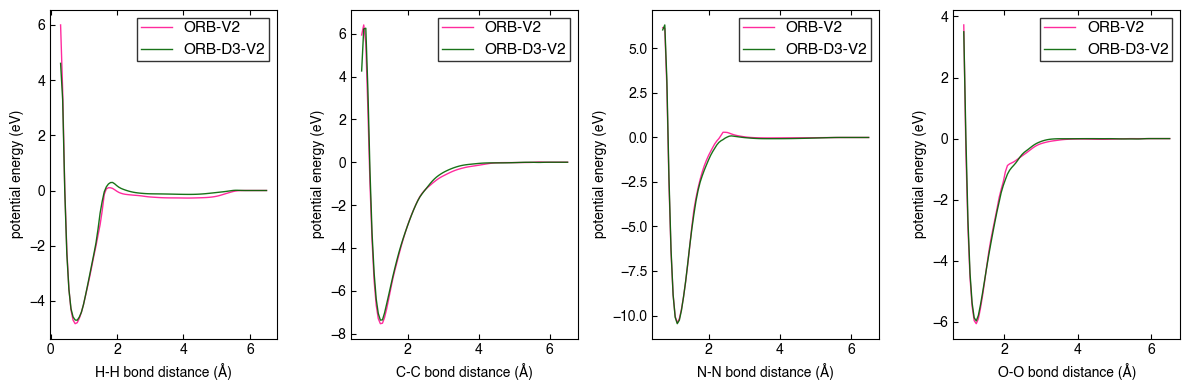

In [33]:
# calculator 
from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')

# define the calculators
calculator_list = [orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ORB-V2', 'ORB-D3-V2']
calculator_colors = ['deeppink', 'darkgreen']


# define the diatomics and the PES scan range
atom_str_list = ['H', 'C', 'N', 'O']
search_list = [[0.3, 6.5], [0.7, 6.5], [0.7, 6.5], [0.9, 6.5]]
workdir = './'

# dimension: [atom_len, calc_len, resolution]
global_energies = []

# dimension: [atom_len, resolution]
global_distances = []

# compute all the PES
for i in range(len(atom_str_list)):
    dist_list, energies = evaluate_diatomics(atom_str_list[i], calculator_list, search_space=search_list[i])
    global_energies.append(energies)
    global_distances.append(dist_list)

plot_diatomics(atom_str_list, calculator_names, global_energies, global_distances, workdir=workdir)